In [ ]:


import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')

# from sglib.verification.drought import get_drought_metrics, calculate_ssi_values
from sglib.utils.load import load_drb_reconstruction

from sglib.plotting.plot import plot_autocorrelation, plot_fdc_ranges, plot_flow_ranges
from sglib.plotting.plot import plot_correlation
from sglib.plotting.drought import drought_metric_scatter_plot

from sglib.methods.nonparametric.kirsch import KirschGenerator
from sglib.methods.nonparametric.kirsch_nowak import KirschNowakGenerator
# from sglib.utils.load import HDF5
from sglib.droughts.ssi import SSIDroughtMetrics

In [ ]:
Q = load_drb_reconstruction()
Q.replace(0, np.nan, inplace=True)
Q.dropna(axis=1, how='any', inplace=True)


Q_inflows = load_drb_reconstruction(gage_flow=False)
print(f"Loaded reconstruction data with {Q.shape[0]// 365} years of daily data for {Q.shape[1]} sites.")

Q_monthly = Q.resample('MS').sum()


Loaded reconstruction data with 79 years of daily data for 30 sites.


In [ ]:
# Initialize the generator
kn_gen = KirschNowakGenerator(Q, debug=False)

# Preprocess the data
kn_gen.preprocessing()

# Fit the model
print("Fitting the model...")
kn_gen.fit()

# Generate 10 years
print("Generating synthetic ensemble...")
n_years = 50
n_realizations = 50
syn_ensemble = kn_gen.generate(n_realizations=n_realizations,
                                n_years=n_years, 
                                as_array=False)


Fitting the model...
Fitting multisite NowakDisaggregator
Generating synthetic ensemble...


In [ ]:
### Create marginal catchment inflows by subtracting upstream inflows
from pywrdrb.pre.flows import _subtract_upstream_catchment_inflows

inflow_ensemble = {}
for real in syn_ensemble:
    
    flows_i = syn_ensemble[real].copy()
    flows_i['delTrenton'] = 0.0
    inflow_ensemble[real] = _subtract_upstream_catchment_inflows(flows_i)
inflow_ensemble

{0:             cannonsville     pepacton   neversink  wallenpaupack    prompton  \
 2024-01-01    520.977895   542.892947  125.362194     171.977664   25.867059   
 2024-01-02    521.115516   536.302804  122.653826     185.830180   26.685397   
 2024-01-03    521.115516   553.842368  119.959427     180.111059   27.410585   
 2024-01-04    502.426519   570.156936  117.308831     184.694868   27.860020   
 2024-01-05    479.688477   471.110340  114.659217     155.728015   26.310375   
 ...                  ...          ...         ...            ...         ...   
 2028-12-27   1846.637422  1884.634475  512.245621     980.416512  266.438149   
 2028-12-28   2528.476486  2129.910751  694.468287    1386.771292  445.543794   
 2028-12-29   1700.967626  1723.325490  431.561272     925.846992  201.308824   
 2028-12-30   1569.081048  1602.707324  378.792243     837.096650  162.823313   
 2028-12-31   1446.186120  1464.561068  342.526303     772.877026  148.021194   
 
             shoholaMar

In [ ]:
# Format syntehtic ensemble as {site: realizations}

Q_syn = {}
Qs_inflows = {}
syn_datetime = syn_ensemble[0].index
for site in syn_ensemble[0].columns:
    Q_syn[site] = np.zeros((len(syn_datetime), n_realizations),
                 dtype=float)
    Qs_inflows[site] = np.zeros((len(syn_datetime), n_realizations),
                    dtype=float)
    
    
    for i in range(n_realizations):
        Q_syn[site][:, i] = syn_ensemble[i][site].values 
        Qs_inflows[site][:, i] = inflow_ensemble[i][site].values
            
    # Convert to DataFrame
    Q_syn[site] = pd.DataFrame(Q_syn[site], 
                               index=syn_datetime, 
                               columns=[i for i in range(n_realizations)])
    Qs_inflows[site] = pd.DataFrame(Qs_inflows[site],
                                    index=syn_datetime, 
                                    columns=[i for i in range(n_realizations)])

# Q_syn['cannonsville']

In [ ]:
from sglib.utils.load import HDF5Manager

fname = "../pywrdrb_inputs/stationary_ensemble/catchment_inflows_mgd.hdf5"
HDF5Manager.save_to_hdf5(fname, inflow_ensemble,
                  datetime_index=inflow_ensemble[0].index,
                  site_names=list(inflow_ensemble[0].columns))



In [ ]:
# SSI = SSIDroughtMetrics(timescale='M', window=12)
# ssi = SSI.calculate_ssi(data=syn_ensemble[0].iloc[:, 0])
# syn_droughts = SSI.calculate_drought_metrics(ssi)


# SSI = SSIDroughtMetrics(timescale='M', window=12)
# syn_ssi = pd.DataFrame(index=syn_ensemble[0].index,
#                        columns=np.arange(0, n_realizations))
# for i in range(n_realizations):
#     syn_ssi.loc[:,i] = SSI.calculate_ssi(data=syn_ensemble[i].loc[:, 'delMontague'])
#     if i == 0:
#         syn_droughts = SSI.calculate_drought_metrics(syn_ssi.loc[:,i])
#     else:
#         syn_droughts = pd.concat([syn_droughts, SSI.calculate_drought_metrics(syn_ssi.loc[:,i])], axis=0)


# drought_metric_scatter_plot(obs_droughts, syn_drought_metrics=syn_droughts, 
#                             x_char='severity', y_char='magnitude', color_char='duration')


# SSI = SSIDroughtMetrics(timescale='M', window=12)
# ssi_obs = SSI.calculate_ssi(data=Q_monthly.loc[:,'delMontague'])
# obs_droughts = SSI.calculate_drought_metrics(ssi_obs)

# drought_metric_scatter_plot(obs_droughts, syn_drought_metrics=None, 
#                             x_char='severity', y_char='magnitude', color_char='duration')
# SSI = SSIDroughtMetrics(timescale='M', window=12)
# ssi_obs = SSI.calculate_ssi(data=Q.iloc[:,0])
# obs_droughts = SSI.calculate_drought_metrics(ssi_obs)

# drought_metric_scatter_plot(obs_droughts, syn_droughts, color_char='duration',)

In [ ]:
Q.columns

Index(['cannonsville', 'pepacton', 'neversink', 'wallenpaupack', 'prompton',
       'shoholaMarsh', 'mongaupeCombined', 'beltzvilleCombined', 'fewalter',
       'merrillCreek', 'hopatcong', 'nockamixon', 'assunpink', 'ontelaunee',
       'stillCreek', 'blueMarsh', 'greenLane', '01425000', '01417000',
       'delLordville', '01436000', '01433500', 'delMontague', '01449800',
       '01447800', 'delDRCanal', '01463620', 'outletAssunpink', '01470960',
       'outletSchuylkill'],
      dtype='object')

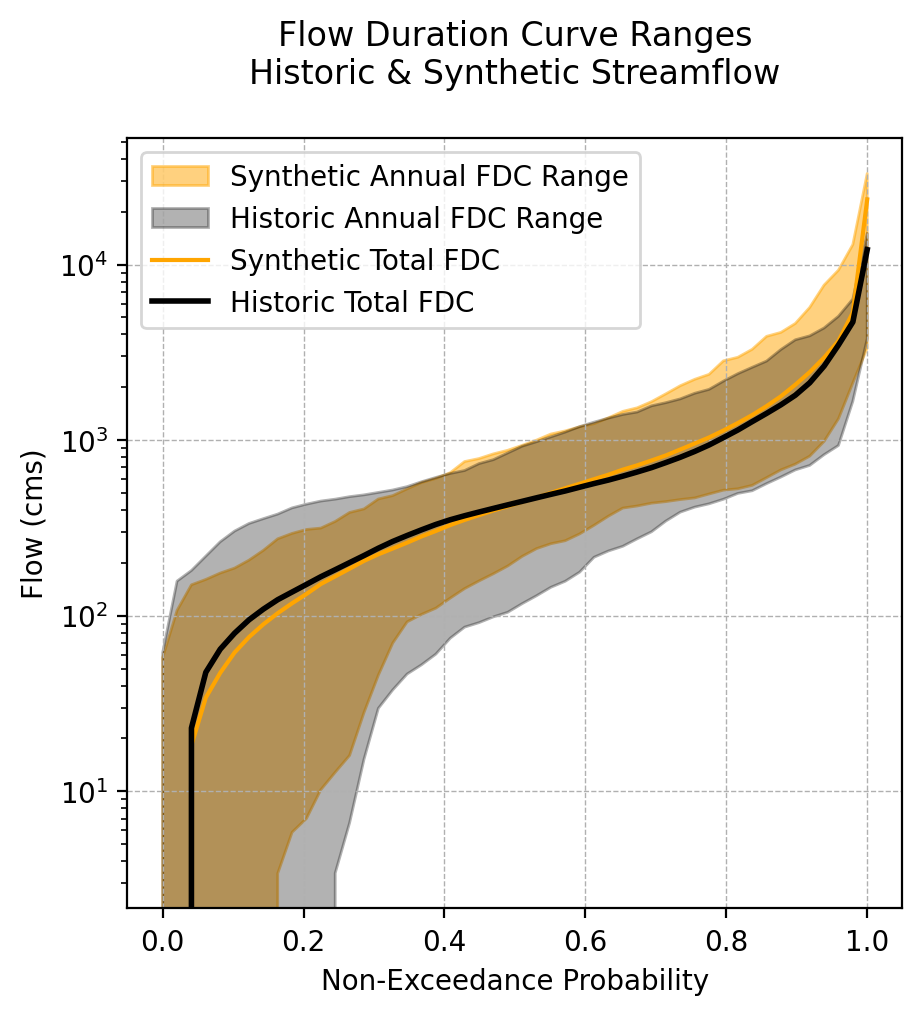

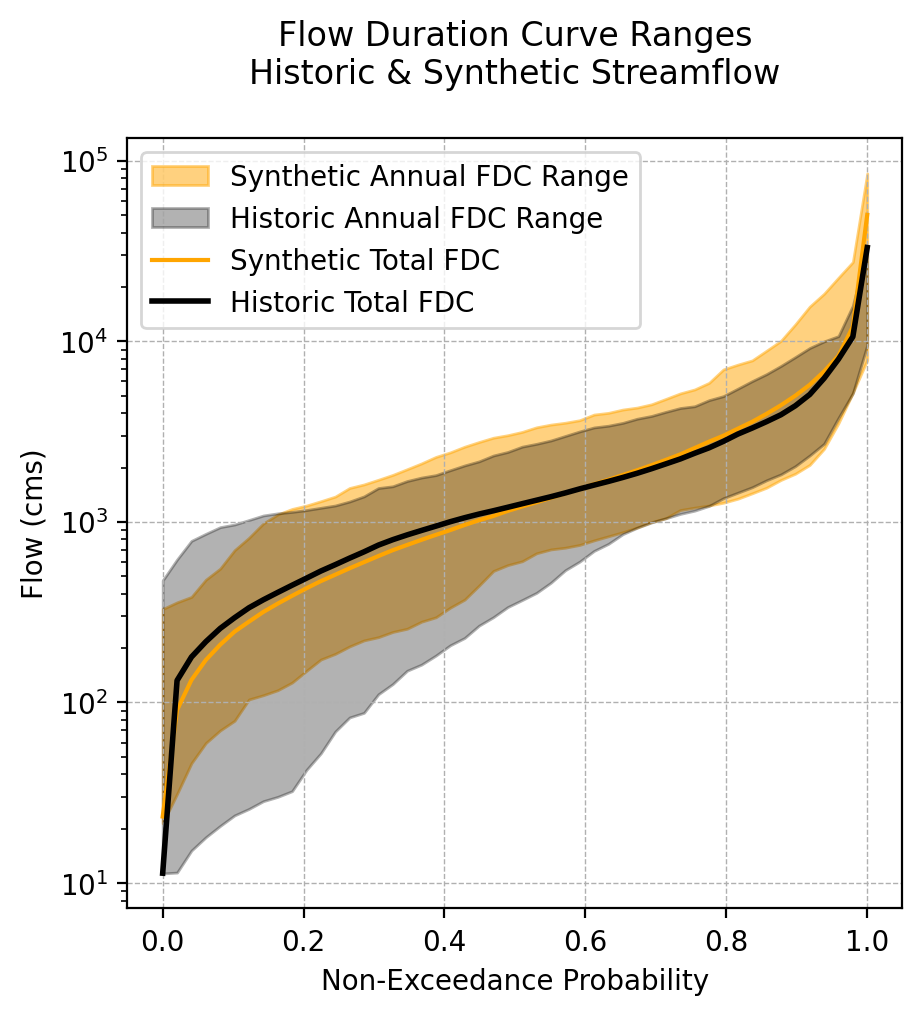

In [ ]:
plot_site = 'delLordville'

# plot_autocorrelation(Q.loc[:, plot_site], 
#                      Q_syn[plot_site], 
#                      lag_range=np.arange(1,60, 5), timestep='daily')

# plot_flow_ranges(Q.loc[:,plot_site], 
#                  Q_syn[plot_site], 
#                  timestep='daily')

plot_fdc_ranges(Q_inflows.loc[:,plot_site], 
                Qs_inflows[plot_site])

plot_fdc_ranges(Q.loc[:,plot_site],
                Q_syn[plot_site])

# plot_correlation(Q, syn_ensemble[2])

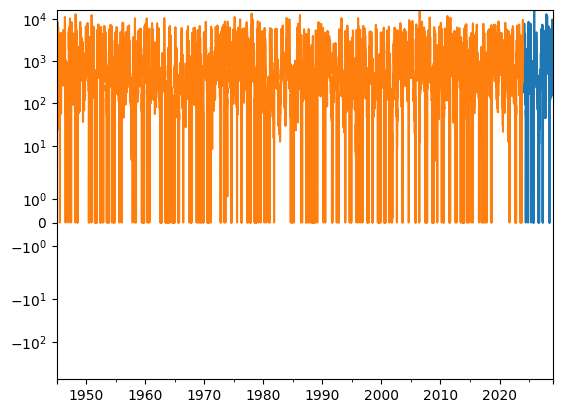

In [ ]:
Qs_inflows[plot_site].loc[:,0].plot(label='Synthetic')
Q_inflows.loc[:,plot_site].plot(label='Observed')
plt.yscale('symlog')